# Insurance Expenses Prediction
##### *Dataset taken from Kaggle.com (https://www.kaggle.com/datasets/mirichoi0218/insurance)*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings
from collections import Counter

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
pal = sns.color_palette('rocket')
pal.as_hex()[:]

['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']

In [3]:
pal.as_hex()

['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']

## Nature of the Dataset

In [4]:
df = pd.read_csv('InsuranceExpenses.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
print('Number of Duplicate values:', df.duplicated().sum())

Number of Duplicate values: 1


As a preliminary inspection, the dataset contained no missing data along its columns but revealed one duplicate across its rows. It is then necessary to eliminate the duplicate to straighten its reliability as we move further down the analysis. 

In [6]:
df = df.drop_duplicates()
print('Number of Duplicate values:', df.duplicated().sum())

Number of Duplicate values: 0


In [7]:
for cat in df.select_dtypes('object').columns:
    print('The "%s" attribute contains:' % (cat) , df[cat].unique())

The "sex" attribute contains: ['female' 'male']
The "smoker" attribute contains: ['yes' 'no']
The "region" attribute contains: ['southwest' 'southeast' 'northwest' 'northeast']


In [8]:
for dis in df.select_dtypes('int64').columns:
    print('The "%s" attribute contains:' % (dis) , df[dis].unique())

The "age" attribute contains: [19 18 28 33 32 31 46 37 60 25 62 23 56 27 52 30 34 59 63 55 22 26 35 24
 41 38 36 21 48 40 58 53 43 64 20 61 44 57 29 45 54 49 47 51 42 50 39]
The "children" attribute contains: [0 1 3 2 5 4]


About the features/attributes:

- The Body Mass Index (*bmi*) is a float variable that describes a person's weight distribution. It is derived from the body mass divided by the square of the body height.
- Sex (*sex*) is a dichotomous category variable that describes whether a person is male or female.
- Age (*age*) in this data is a discrete variable that ranges from 19 to 64 years old
- The number of children (*children*) a person has ranges from 0 to 5 children.
- The smoking habit (*smoker*) simply describes whether a person smokes or not. It is also dichotomous in nature.
- Region (*region*) is divided into 4 major areas: SW, SE, NW, NE.

About the target:

- Expenses (*expenses*) is a float type that is assumed to be affected by all/some of the features above. Since the data has not provided any particular currency for this variable, it will remain unitless all throughout the analysis.

In [9]:
X_int = df.select_dtypes('int64')
X_flt = df.select_dtypes('float64').drop(['expenses'], axis=1)
X_cat = df.select_dtypes('object')
Y = df['expenses']

## Exploratory Data Analysis

### Target Variable: Expenses

<AxesSubplot:xlabel='expenses', ylabel='Density'>

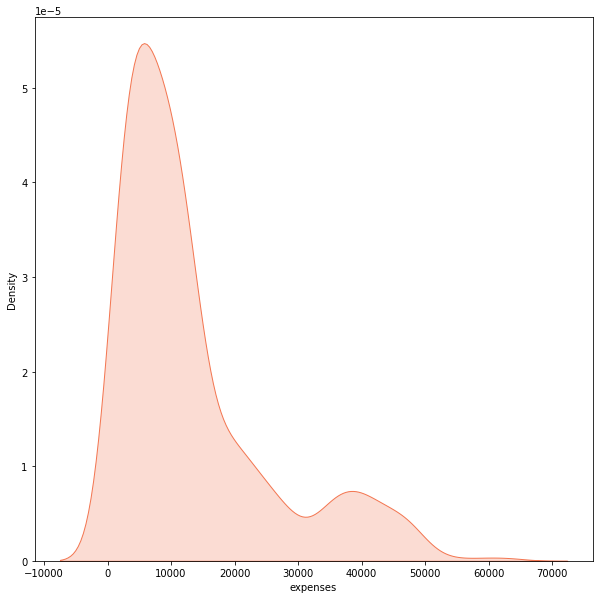

In [10]:
fig_1, axs_1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.kdeplot(Y, fill=True, color='#f37651')

In [11]:
df['expenses'].median()

9386.16

In [12]:
df['expenses'].mean()

13279.121637995511

The *expenses* shows a right-skewed distribution where most points lie around 9000 while probabilities taper off at high values. Given this statistical nature, it is best to represent the target with the median as the central tendency. On the other hand, it is misleading to represent it with its mean as this measure of central tendency considers every data point (even outliers in a skewed distribution).

### Feature: Age

<AxesSubplot:xlabel='age', ylabel='count'>

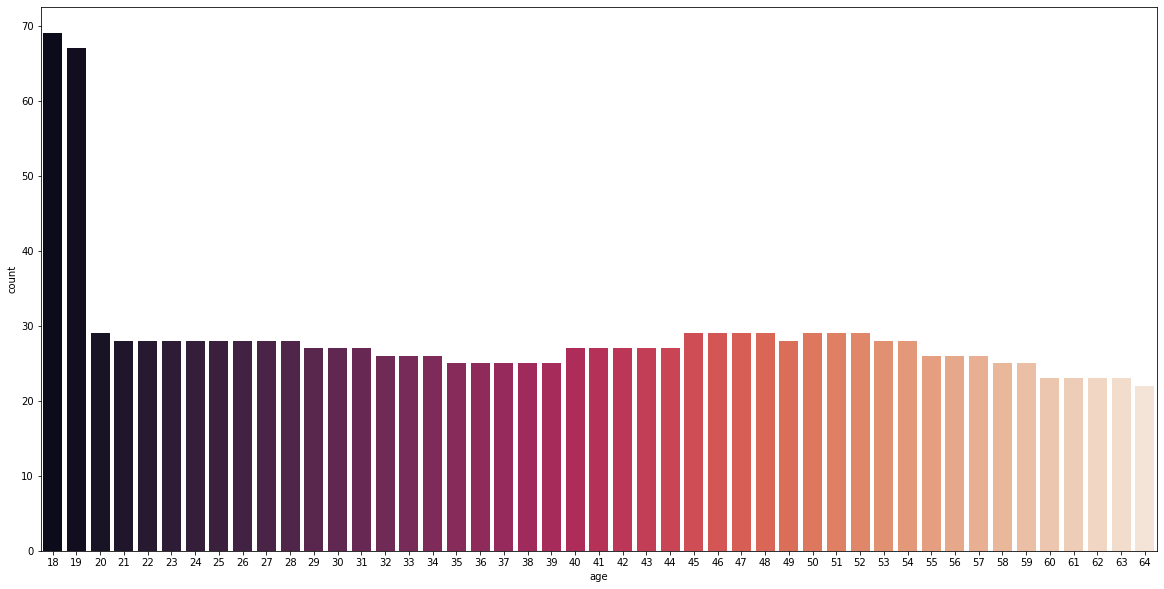

In [13]:
fig_2, axs_2 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.countplot(X_int['age'],  palette='rocket')

It can be initially seen that the dataset is mainly comprised of 18- and 19-year-olds at a frequency above 65, while the rest are around the same frequencies between 20 and 30. 

To ease the data visualization, the ages were binned into eight categories as shown below, and were analyzed against the target variable.

In [14]:
def age_categorizer(age):
    if age <= 23:
        return '18-23'
    elif age <= 29 and age >= 24:
        return '24-29'
    elif age <= 35 and age >= 30:
        return '30-35'
    elif age <= 41 and age >= 36:
        return '36-41'
    
    elif age <= 47 and age >= 42:
        return '42-47'
    elif age <= 53 and age >= 48:
        return '48-53'
    elif age <= 59 and age >= 54:
        return '54-59'
    elif age <= 65 and age >= 60:
        return '60-65'

df['age_group'] = df['age'].apply(lambda x: age_categorizer(x))

<AxesSubplot:xlabel='age_group', ylabel='expenses'>

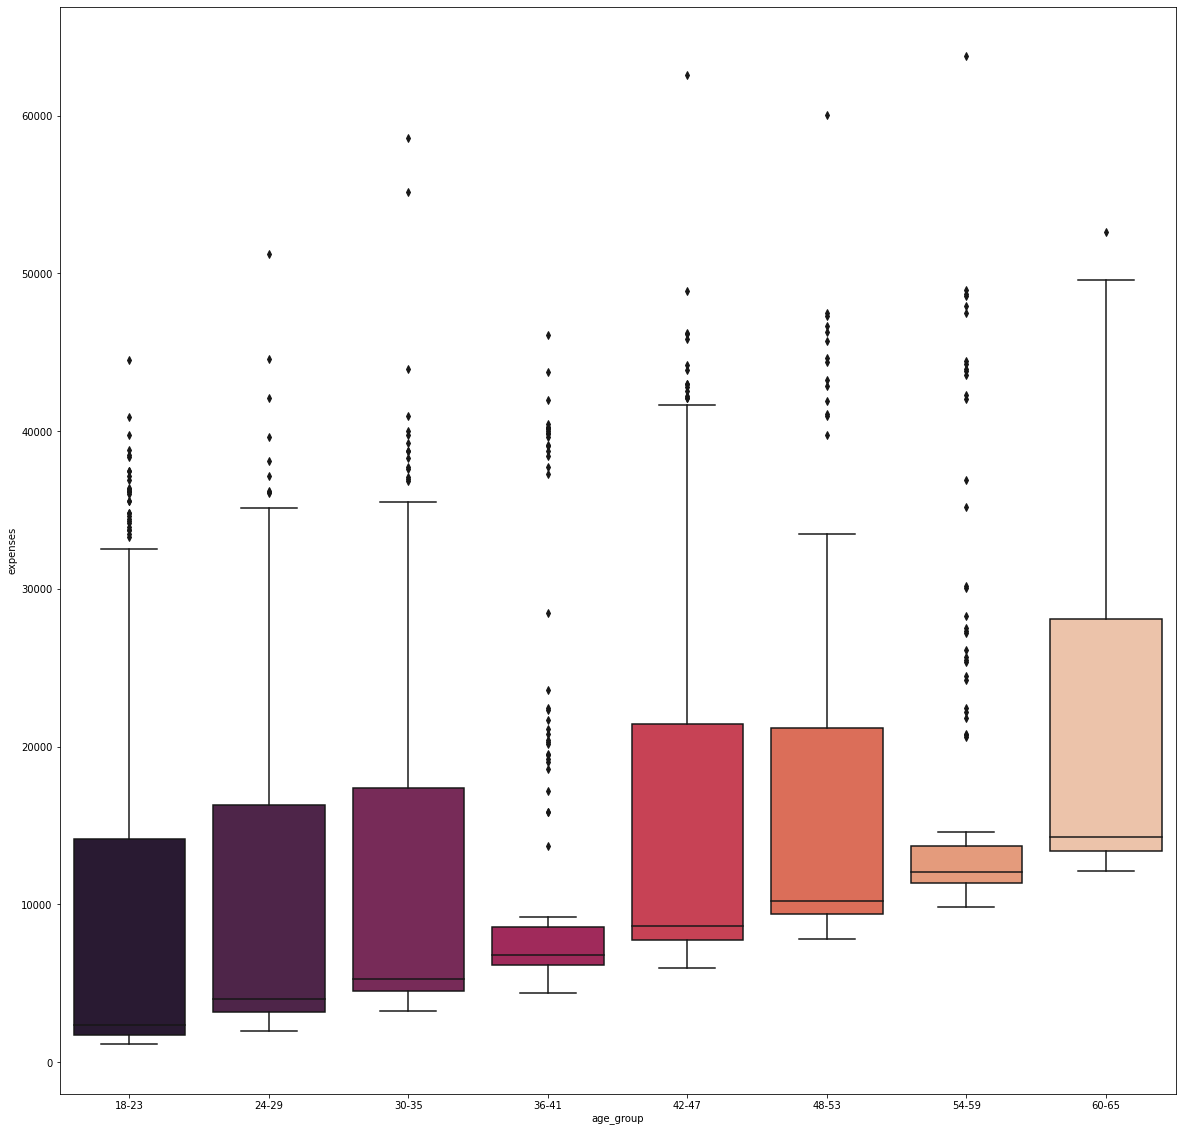

In [15]:
fig_3, axs_3 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
sns.boxplot(x='age_group', y='expenses', data=df, palette='rocket', order=['18-23', '24-29', '30-35', '36-41', 
                                                                                      '42-47', '48-53', '54-59', '60-65'])

It is evident that as the age group increases, the base cost for each category steadily increases. However, it can be further noticed as to how, at each category, there are distinct patches of data points as the expenses increase vertically. This will be further analyzed later on.

### Feature: Number of Children

<AxesSubplot:xlabel='children', ylabel='count'>

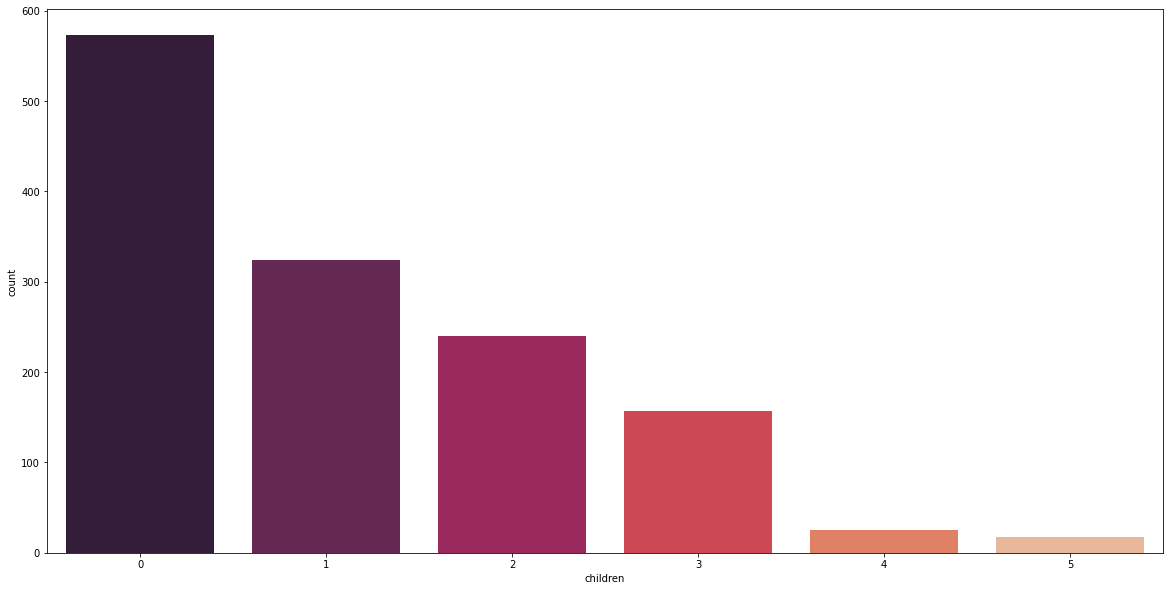

In [16]:
fig_4, axs_4 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.countplot(X_int['children'],  palette='rocket')

Majority of the individuals in the dataset have no children. It is interesting to see that 66% of 18- to 23-year-olds and 70% of 60- to 65-year-olds have no children.

In [17]:
age_v_children = df.groupby(['age_group'])['children'].value_counts(normalize=True)
print(age_v_children)

age_group  children
18-23      0           0.658635
           1           0.164659
           2           0.104418
           3           0.052209
           5           0.012048
           4           0.008032
24-29      0           0.467066
           1           0.203593
           2           0.191617
           3           0.095808
           4           0.029940
           5           0.011976
30-35      1           0.356688
           0           0.235669
           2           0.203822
           3           0.165605
           4           0.019108
           5           0.019108
36-41      1           0.305195
           2           0.253247
           0           0.220779
           3           0.155844
           4           0.032468
           5           0.032468
42-47      1           0.321429
           2           0.291667
           0           0.238095
           3           0.125000
           5           0.017857
           4           0.005952
48-53      0        

<AxesSubplot:xlabel='children', ylabel='expenses'>

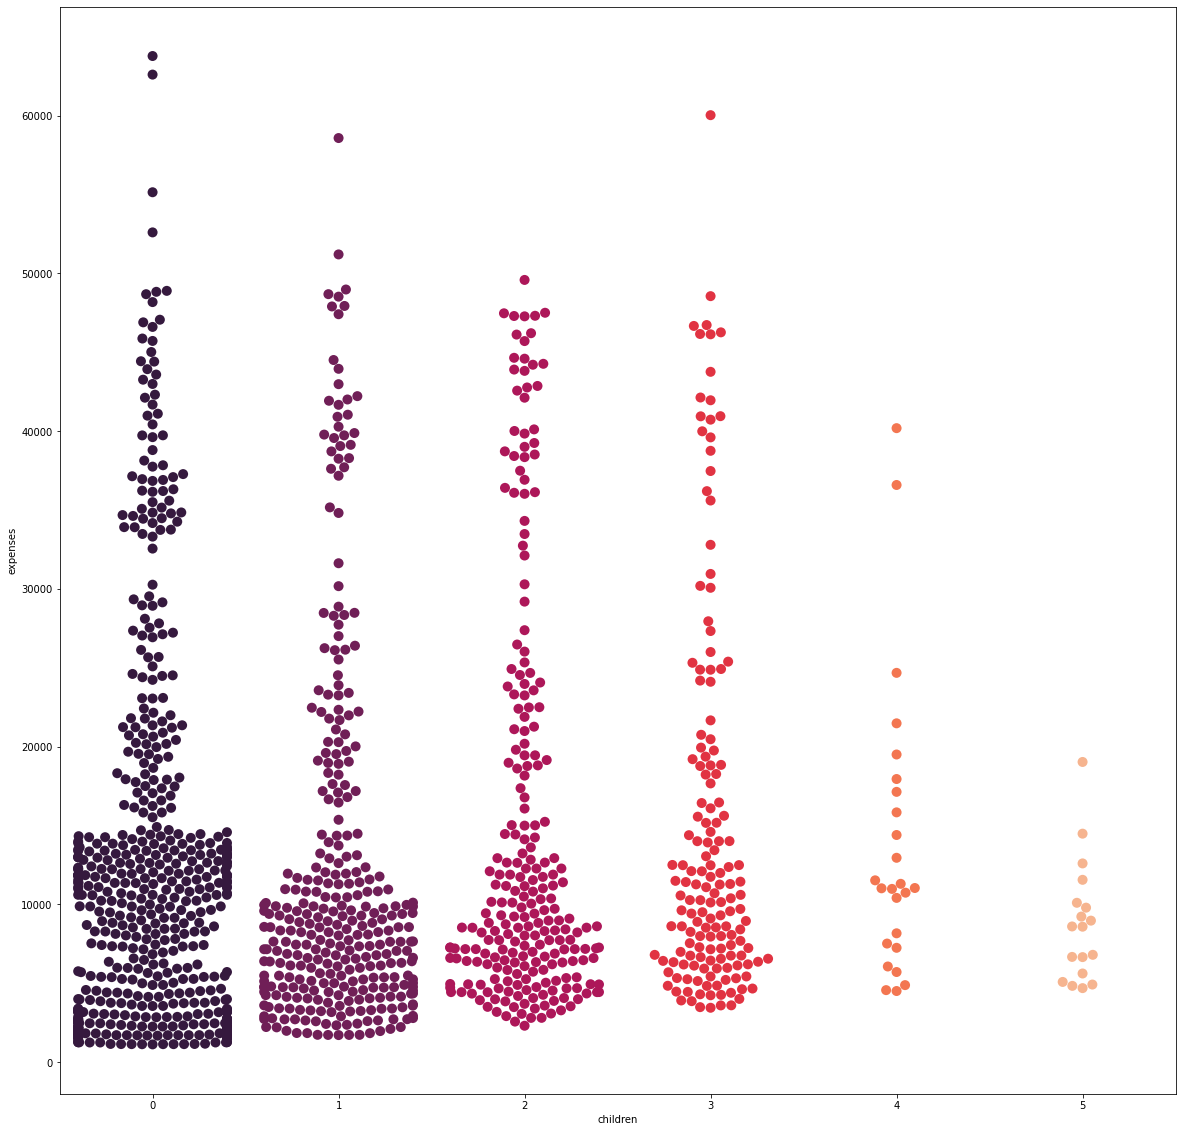

In [18]:
fig_5, axs_5 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
sns.swarmplot(x='children', y='expenses', data=df, palette='rocket', size=10)

From the visualization alone, there is no distinguishable trend in expenses as the number of children increases.

### Feature: Body Mass Index

<AxesSubplot:xlabel='bmi', ylabel='expenses'>

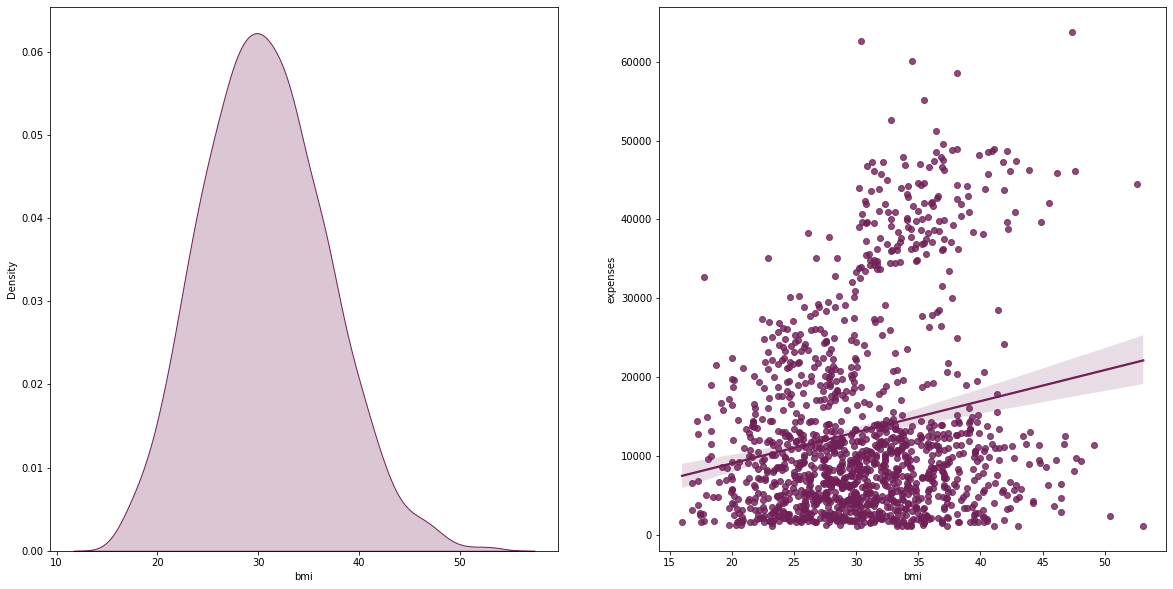

In [19]:
fig_6, axs_6 = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.kdeplot(X_flt['bmi'], fill=True, color='#701f57', ax=axs_6[0])
sns.regplot(x='bmi', y='expenses', data=df, color='#701f57', ax=axs_6[1])

The distribution of the BMI is fairly normal as it is centered around the 30 mark. 

When paired with the target, the plot shows a "scattered" distribution as points move up the y-axis, especially starting around at the 30 to 35 marks. Therefore, to investigate further, the raw BMI values are binned into their natural categories: Underweight, Normal, Overweight, or Obese.

In [20]:
def bmi_categorizer(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi >= 18.5 and bmi < 25:
        return "Normal"
    elif bmi >= 25 and bmi < 30:
        return "Overweight"
    else:
        return "Obese"

df['bmi_group'] = df['bmi'].apply(lambda x: bmi_categorizer(x))

<AxesSubplot:xlabel='bmi_group', ylabel='expenses'>

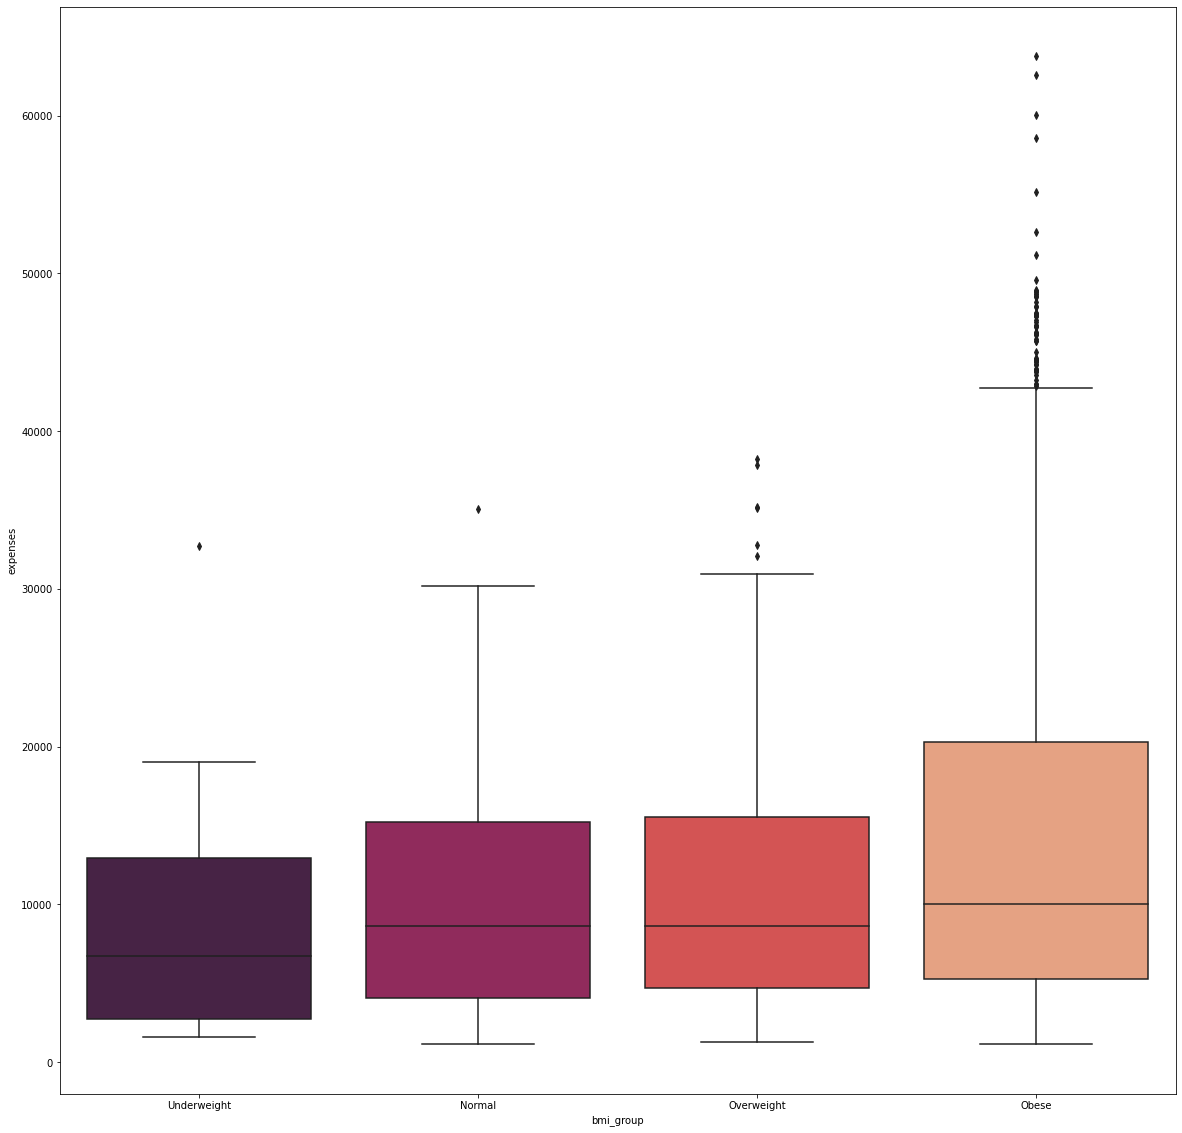

In [21]:
fig_7, axs_7 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
sns.boxplot(x='bmi_group', y='expenses', data=df, palette='rocket', order=['Underweight', 'Normal',
                                                                                       'Overweight', 'Obese'])

Majority of the people in the dataset are obese while underweights are at the minority. 

It was shown that obese patients have the most number of expenses which are considered to be outliers. In this case, there were 79 individuals who spent more than 40,000 for their medical bills to which 63,770 was the largest amount spent.

In [22]:
obese_vs_expenses = df.loc[(df['bmi_group']=='Obese') & (df['expenses'] > 40000)]
obese_vs_expenses

,age,sex,bmi,children,smoker,region,expenses,age_group,bmi_group
34,28,male,36.4,1,yes,southwest,51194.56,24-29,Obese
39,60,male,39.9,0,yes,southwest,48173.36,60-65,Obese
55,58,male,37.0,2,yes,northwest,47496.49,54-59,Obese
86,57,female,31.2,0,yes,northwest,43578.94,54-59,Obese
94,64,female,31.3,2,yes,southwest,47291.06,60-65,Obese
...,...,...,...,...,...,...,...,...,...
1241,64,male,37.0,2,yes,southeast,49577.66,60-65,Obese
1284,61,male,36.3,1,yes,southwest,47403.88,60-65,Obese
1300,45,male,30.4,0,yes,southeast,62592.87,42-47,Obese
1301,62,male,30.9,3,yes,northwest,46718.16,60-65,Obese


### Feature: Sex

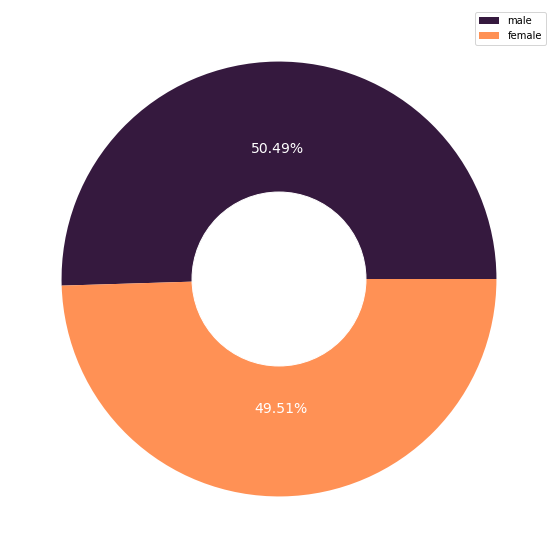

In [23]:
sex_count = X_cat['sex'].value_counts().to_frame().rename(columns={'sex':'frequency'})

fig_8, axs_8 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
plt.pie(sex_count['frequency'], autopct='%.2f%%',
       colors=['#35193e', '#ff9155'], textprops={'color':"w", 'fontsize': 14})
plt.legend(sex_count.index)

hole=plt.Circle( (0,0), 0.4, color='white')
p=plt.gcf()
p.gca().add_artist(hole)

<AxesSubplot:xlabel='sex', ylabel='expenses'>

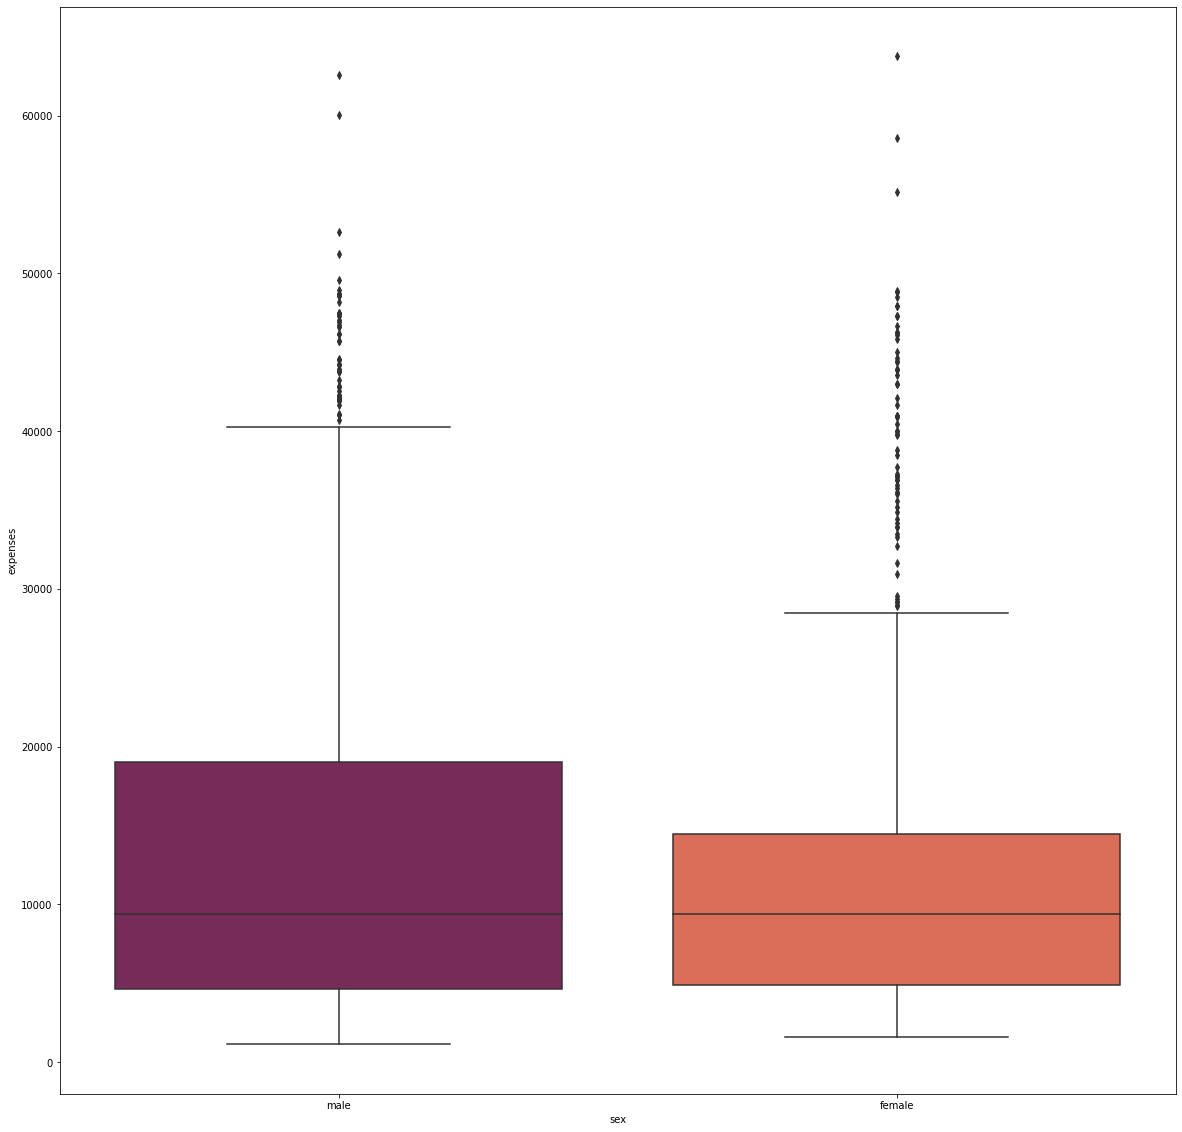

In [24]:
fig_9, axs_9 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
sns.boxplot(x='sex', y='expenses', data=df, palette='rocket', order=['male', 'female'])

The dataset contained an almost equal number of males and females, and showed no significant difference in terms of their median expenditure. However, the females have a tighter expense distribution than males.

### Feature: Region

<AxesSubplot:xlabel='region', ylabel='count'>

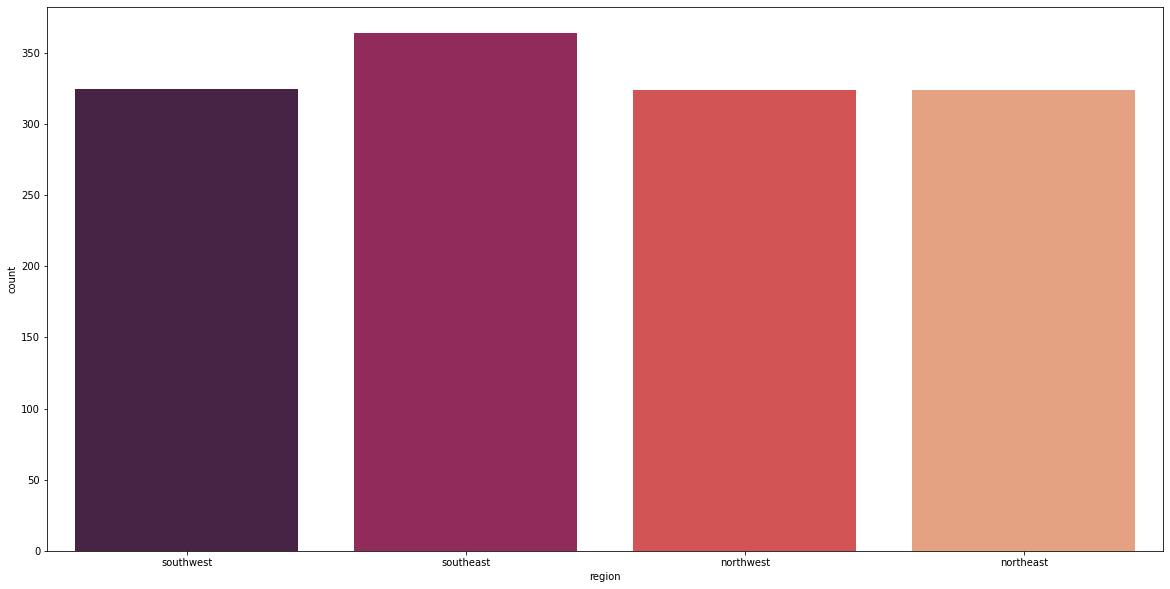

In [25]:
fig_10, axs_10 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.countplot(X_cat['region'], palette='rocket')

<AxesSubplot:xlabel='region', ylabel='expenses'>

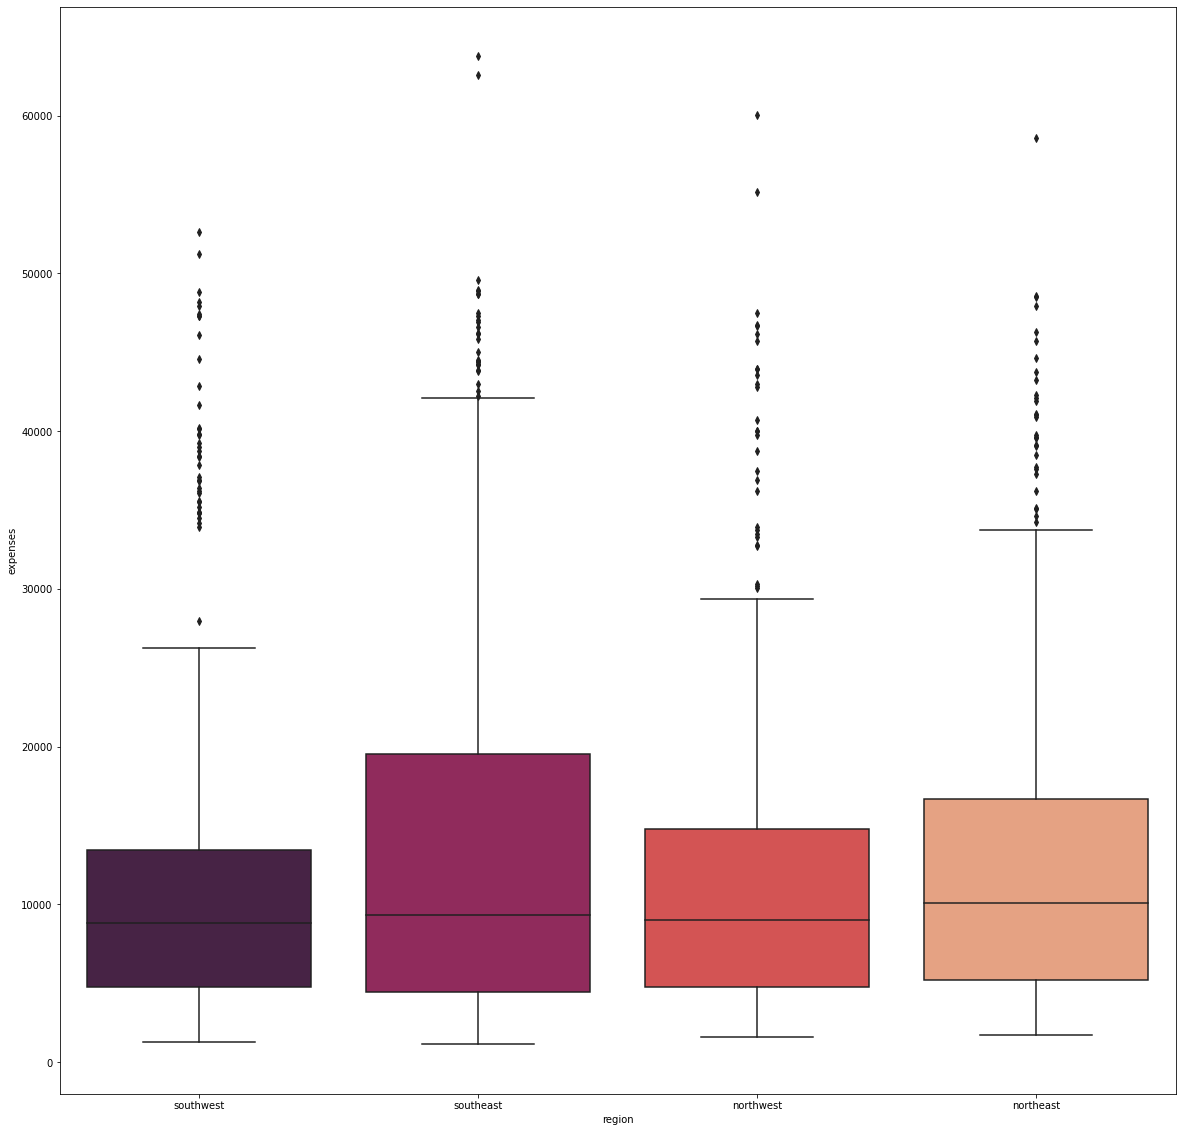

In [26]:
fig_11, axs_11 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
sns.boxplot(x='region', y='expenses', data=df, palette='rocket', order=['southwest', 'southeast',
                                                                                     'northwest', 'northeast'])

There were no significant difference in the median expenditure with respect to where the individuals are from.

### Feature: Smoking Habit

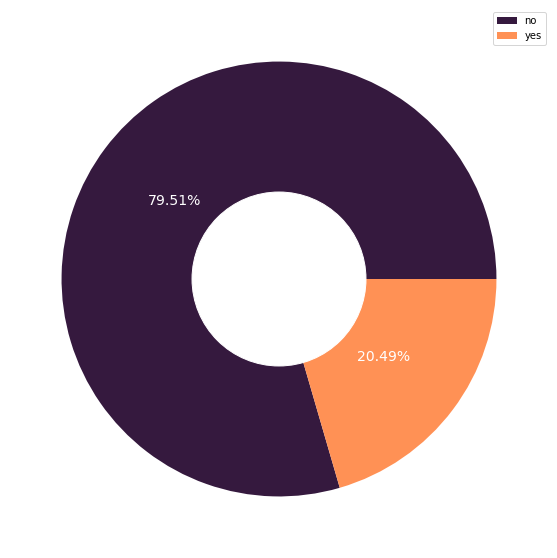

In [27]:
smoker_count = X_cat['smoker'].value_counts().to_frame().rename(columns={'smoker':'frequency'})

fig_12, axs_12 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
plt.pie(smoker_count['frequency'], autopct='%.2f%%',
       colors=['#35193e', '#ff9155'], textprops={'color':"w", 'fontsize': 14})
plt.legend(smoker_count.index)

hole=plt.Circle( (0,0), 0.4, color='white')
p=plt.gcf()
p.gca().add_artist(hole)

<AxesSubplot:xlabel='smoker', ylabel='expenses'>

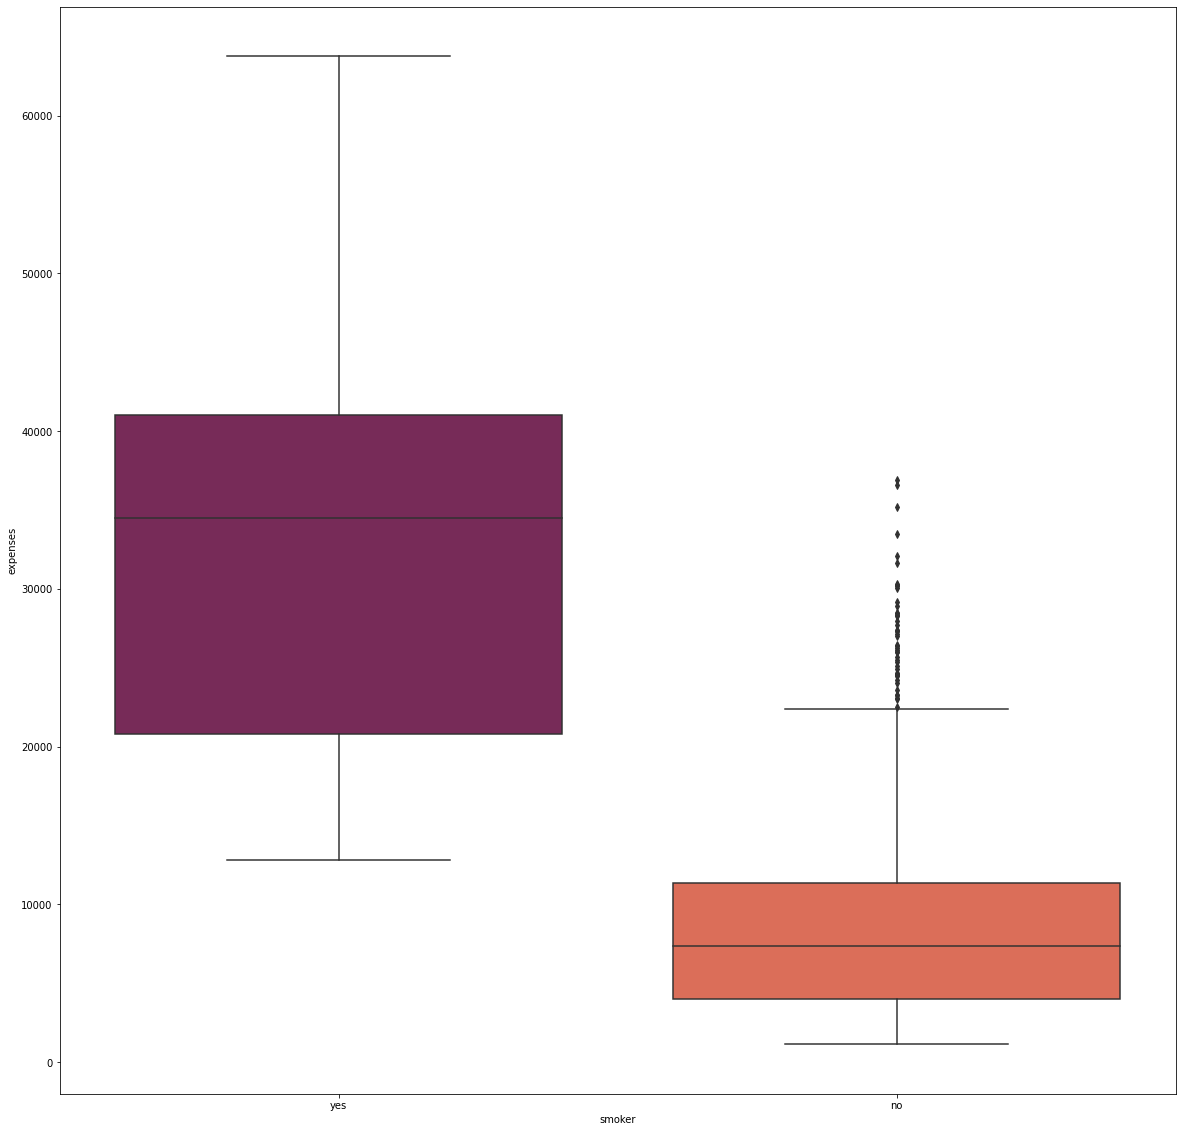

In [28]:
fig_13, axs_13 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
sns.boxplot(x='smoker', y='expenses', data=df, palette='rocket', order=['yes', 'no'])

Approximately 80% of the individuals in the dataset are non-smokers, and they incurred significantly lower medical costs. On the other hand, many smokers have higher medical costs that is at least 13,000. 

### Feature Interactions

#### Age and BMI

The swarmplot shows that, at each age group, obese individuals are at the upper spectrum in terms of medical costs. There is a clear delineation starting at the 30,000  mark showing people above this are mainly obese individuals. As previously discussed, this particular BMI group frequently experiences outlying medical costs.

<AxesSubplot:xlabel='age_group', ylabel='expenses'>

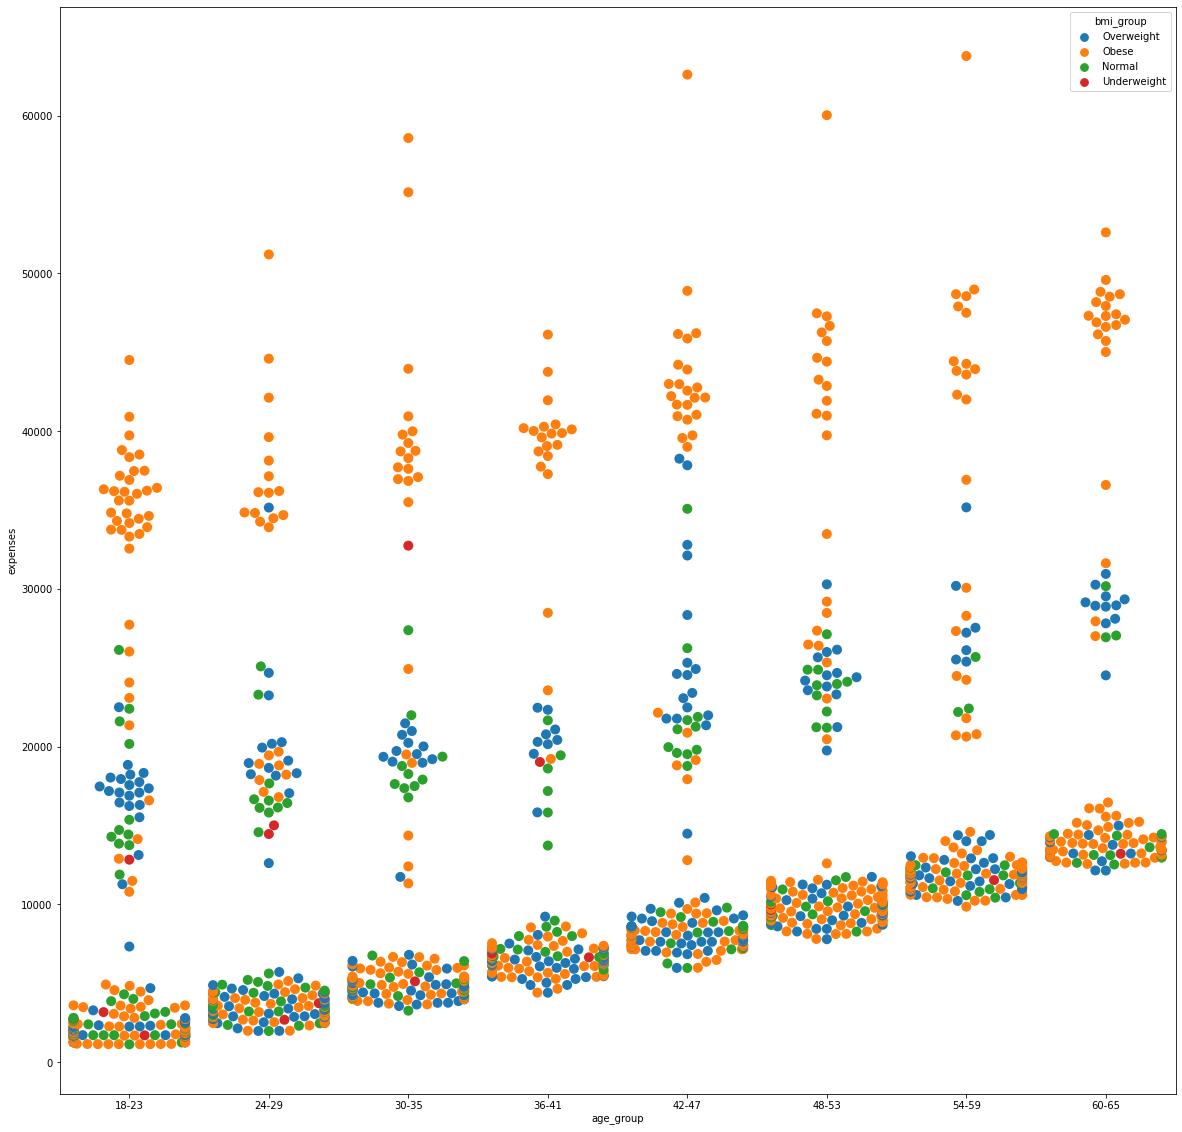

In [29]:
fig_14, axs_14 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
sns.swarmplot(x='age_group', y='expenses', data=df, hue='bmi_group', size=10, order=['18-23', '24-29', '30-35', '36-41', 
                                                                                      '42-47', '48-53', '54-59', '60-65'])

#### Age and Smoking Habit

By the same token, medical expenses above 30,000 were mainly associated to smokers while non-smokers purely reside at the lower end of the spectrum below 15,000. Data points between these values are observed to be a mix of smoking and non-smoking individuals to which the costs can be attributed to other features.

<AxesSubplot:xlabel='age_group', ylabel='expenses'>

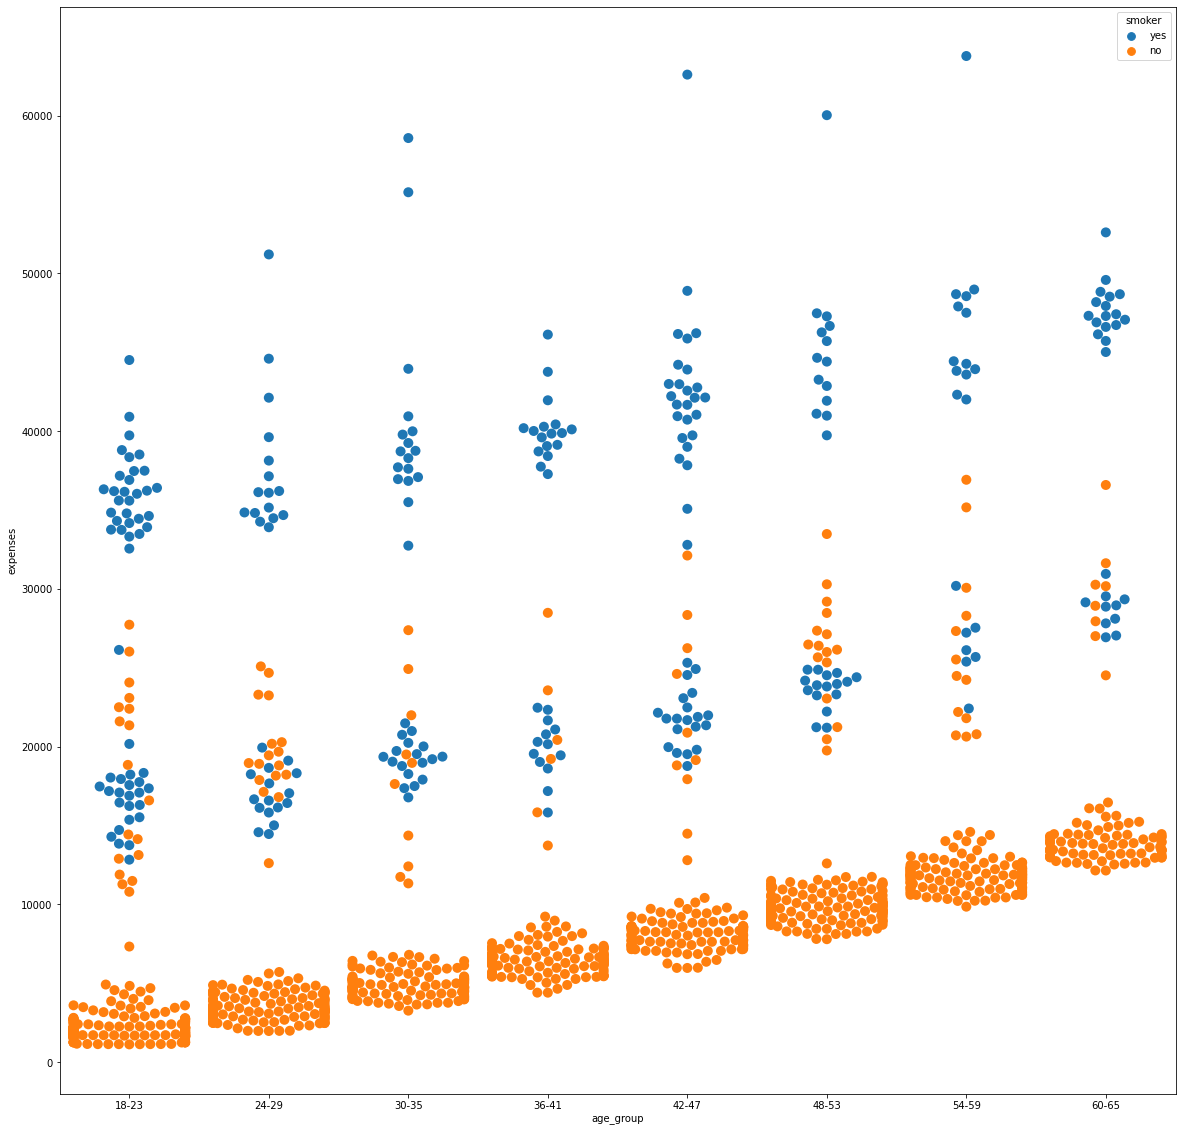

In [30]:
fig_15, axs_15 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
sns.swarmplot(x='age_group', y='expenses', data=df, hue='smoker', size=10, order=['18-23', '24-29', '30-35', '36-41', 
                                                                                      '42-47', '48-53', '54-59', '60-65'])

#### Body Mass Index and Smoking Habit

Pairing the BMI and smoking habit in an analysis showed that smokers remained at the upper spectrum in medical expenses. Furthermore, by looking specifically at the obese group, obese smokers have expenses more than 30,000.

<AxesSubplot:xlabel='bmi_group', ylabel='expenses'>

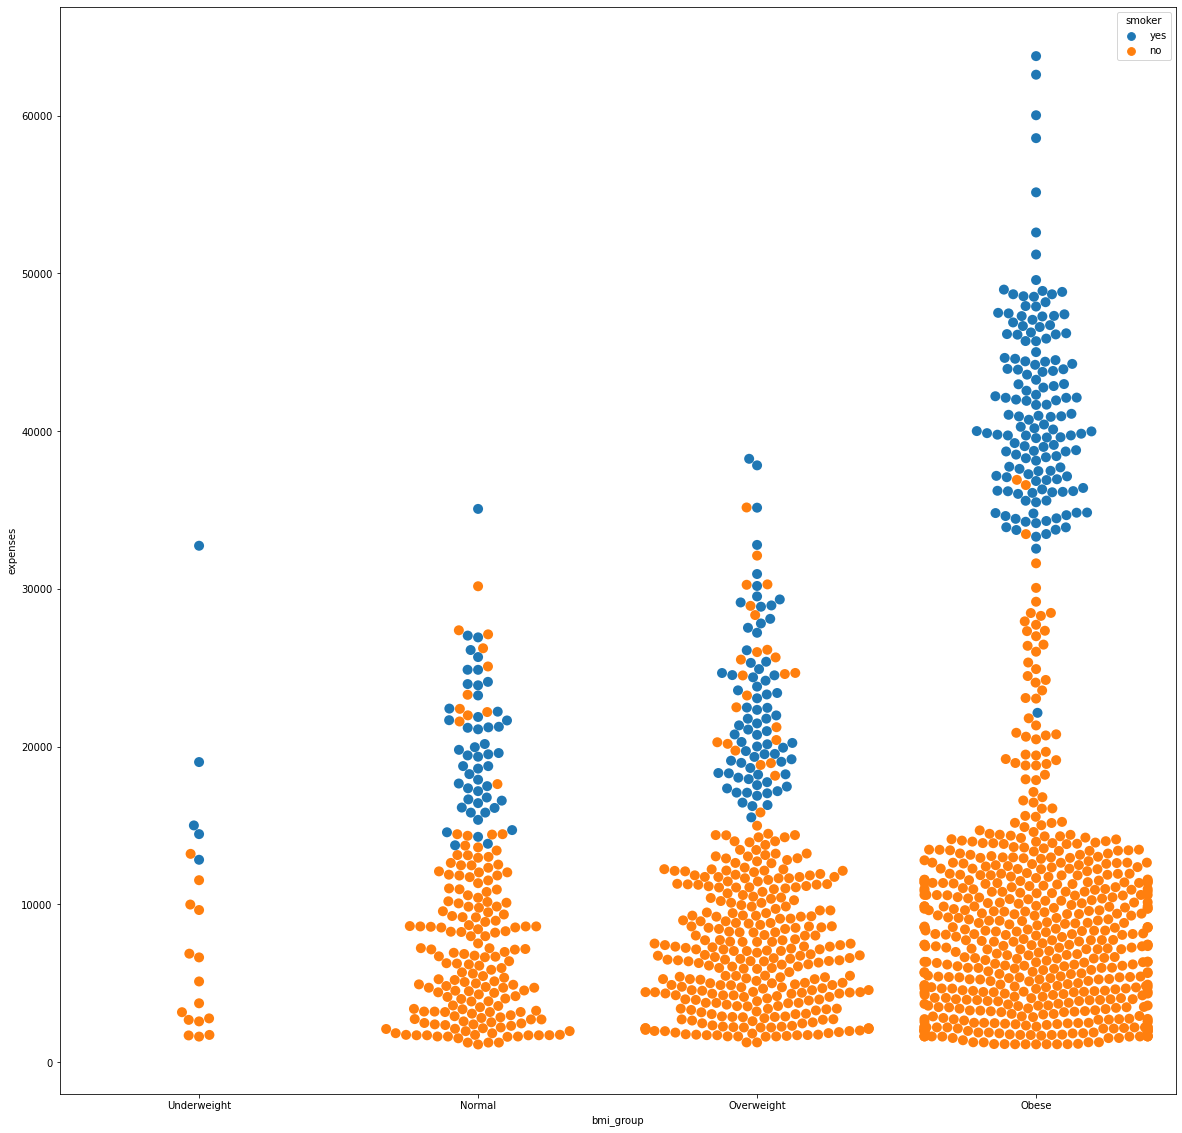

In [31]:
fig_16, axs_16 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
sns.swarmplot(x='bmi_group', y='expenses', data=df, hue='smoker', size=10, order=['Underweight', 'Normal',
                                                                                       'Overweight', 'Obese'])

## Feature Encoding and Scaling

In [32]:
df = df.drop(['age_group', 'bmi_group'], axis=1)

In [33]:
X_int = df.select_dtypes('int64')
X_flt = df.select_dtypes('float64').drop(['expenses'], axis=1)
X_cat = df.select_dtypes('object')
Y = df['expenses']

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
ore = OrdinalEncoder()

In [35]:
X_sex_reg = ohe.fit_transform(X_cat[['sex', 'region', 'smoker']])
X_ohe = pd.DataFrame(X_sex_reg.toarray())
labels = ohe.get_feature_names_out(['sex', 'region', 'smoker'])
X_ohe.columns = labels
X_ohe

# X_ohe = pd.get_dummies(X_cat, drop_first=True)
# X_ohe

,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
1332,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1333,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1334,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1335,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [36]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [37]:
X_flt_scaled = pd.DataFrame(scaler.fit_transform(df[X_flt.columns]), columns=X_flt.columns)
X_flt_scaled

,bmi
0,-0.297619
1,0.404762
2,0.309524
3,-0.916667
4,-0.178571
...,...
1332,0.071429
1333,0.178571
1334,0.773810
1335,-0.547619


In [38]:
X_int_scaled = pd.DataFrame(scaler.fit_transform(df[X_int.columns]), columns=X_int.columns)
X_int_scaled

,age,children
0,-0.833333,-0.5
1,-0.875000,0.0
2,-0.458333,1.0
3,-0.250000,-0.5
4,-0.291667,-0.5
...,...,...
1332,0.458333,1.0
1333,-0.875000,-0.5
1334,-0.875000,-0.5
1335,-0.750000,-0.5


In [39]:
Y_reshaped = Y.values.reshape(-1,1)
Y_scaled = pd.DataFrame(scaler.fit_transform(Y_reshaped), columns = ['expenses'])
Y_scaled

,expenses
0,0.629546
1,-0.643134
2,-0.414452
3,1.057670
4,-0.463364
...,...
1332,0.101952
1333,-0.602800
1334,-0.651170
1335,-0.619425


In [40]:
df_scaled = pd.concat([X_flt_scaled, X_int_scaled, X_ohe, Y_scaled], axis=1)
df_scaled

,bmi,age,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes,expenses
0,-0.297619,-0.833333,-0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.629546
1,0.404762,-0.875000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.643134
2,0.309524,-0.458333,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.414452
3,-0.916667,-0.250000,-0.5,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.057670
4,-0.178571,-0.291667,-0.5,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.463364
...,...,...,...,...,...,...,...,...,...,...,...,...
1332,0.071429,0.458333,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.101952
1333,0.178571,-0.875000,-0.5,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.602800
1334,0.773810,-0.875000,-0.5,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.651170
1335,-0.547619,-0.750000,-0.5,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.619425


In [41]:
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


## Correlation

### Pearson's Coefficient

<AxesSubplot:>

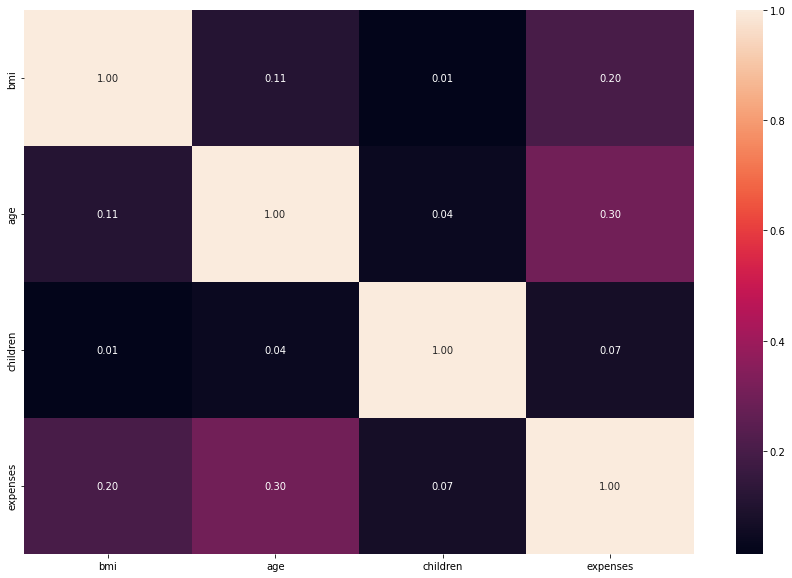

In [42]:
num_corr = pd.concat([X_flt, X_int, Y], axis=1).corr()

fig_17, axs_17 = plt.subplots(figsize=(15,10))
sns.heatmap(num_corr, annot=True, fmt='.2f')

Heatmap showed no significant correlation among features. I would say that the relationships of age and bmi toward the expenses is worth mentioning since they are at 0.30 and 0.20, respectively.

### $\chi^{2}$ Contingency Table

<AxesSubplot:>

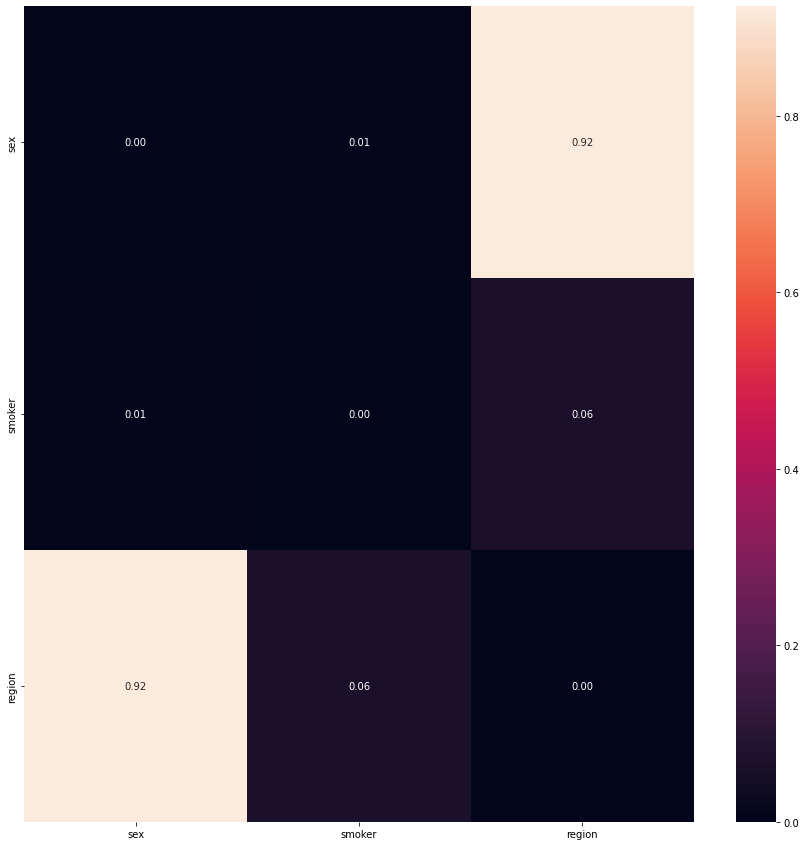

In [43]:
from scipy.stats import chi2_contingency

pvals={}
alpha = 0.05

for i in X_cat.columns.to_list():
    pvals['%s' %(i)] = []
    for j in X_cat.columns.to_list():
        t = pd.crosstab(X_cat['%s' %(i)], X_cat['%s' %(j)], margins=False)
        stat, p, dof, expected = chi2_contingency(t)
        pvals['%s' %(i)].append(p)
        
contingency_table_results = pd.DataFrame(pvals, index=X_cat.columns.to_list())

fig_18, axs_18 = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
sns.heatmap(contingency_table_results, annot=True, fmt='.2f')

Among the categorical attributes, the chi-squared contingency table showed that only the pair region and sex showed no siginificant relationship with one another

## Regression

Regression in machine learning is a supervised learning task used for predicting continuous values. Given a set of input features, the goal of regression is to model the relationship between these features and the target such that the model can make accurate predictions on unseen data.

For this analysis, I implemented three types of approaches: **Linear Regression (Base), Random Forests, and XGBoost.**

In [44]:
from sklearn.model_selection import train_test_split
X_scaled = df_scaled.drop(['expenses'], axis=1)
Y_scaled = df_scaled['expenses']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.33, random_state=42)

In [45]:
X_train

,bmi,age,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
1036,0.011905,0.250000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
467,0.404762,0.708333,0.5,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
39,1.130952,0.875000,-0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
30,0.619048,-0.708333,-0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
242,-0.428571,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1095,0.547619,0.500000,0.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1130,1.845238,-0.500000,0.5,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1294,-1.000000,-0.791667,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
860,-0.285714,-0.041667,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


### Linear Regression (Base)

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lin_reg = LinearRegression()

In [47]:
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [48]:
lin_mse = mean_squared_error(y_test, y_pred)
np.sqrt(lin_mse)

0.521919018853613

In [49]:
r2_score(y_test, y_pred)

0.7727913719512141

Without conducting any changes yet, the model scored 77.28% which is a fairly good start. The model can be studied for further improvements by selecting only a number of features that are deemed significant by the Recursive Feature Elimination algorithm.

#### Recursive Feature Elimination

In [50]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [51]:
def modelling():
    models = dict()
    for i in range(2, len(X_train.columns)):
        rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
        model = LinearRegression()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    return scores

models = modelling()
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>2 -0.486 (0.222)
>3 -0.425 (0.256)
>4 -0.434 (0.279)
>5 -0.388 (0.239)
>6 -0.389 (0.235)
>7 -0.301 (0.074)
>8 -0.299 (0.075)
>9 -0.270 (0.050)
>10 -0.260 (0.050)


It is advised to use 10 features as it incurred the lowest mean squared error.

In [52]:
top =[]
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe.fit(X_train, y_train)
for i in range(X_train.shape[1]):
    print(X_train.columns[i], 'Selected %s, Rank: %.3f' % (rfe.support_[i], rfe.ranking_[i]))
    if rfe.support_[i] == True:
        top.append(X_train.columns[i])

bmi Selected True, Rank: 1.000
age Selected True, Rank: 1.000
children Selected False, Rank: 2.000
sex_female Selected True, Rank: 1.000
sex_male Selected True, Rank: 1.000
region_northeast Selected True, Rank: 1.000
region_northwest Selected True, Rank: 1.000
region_southeast Selected True, Rank: 1.000
region_southwest Selected True, Rank: 1.000
smoker_no Selected True, Rank: 1.000
smoker_yes Selected True, Rank: 1.000


In [53]:
X_train_rfe = X_train[top]
X_test_rfe = X_test[top]

m = LinearRegression()

m.fit(X_train_rfe, y_train)
y_pred = m.predict(X_test_rfe)

In [54]:
m_mse = mean_squared_error(y_test, y_pred)
np.sqrt(m_mse)

0.5241553170629731

In [55]:
r2_score(y_test, y_pred)

0.7708401312929616

Unfortunately, the new results were of slightly lower value than before (decrease of 0.25% in R2) which contradicts my intention for improvements. Therefore, other regression models were explored to see any changes.

<AxesSubplot:xlabel='expenses', ylabel='Density'>

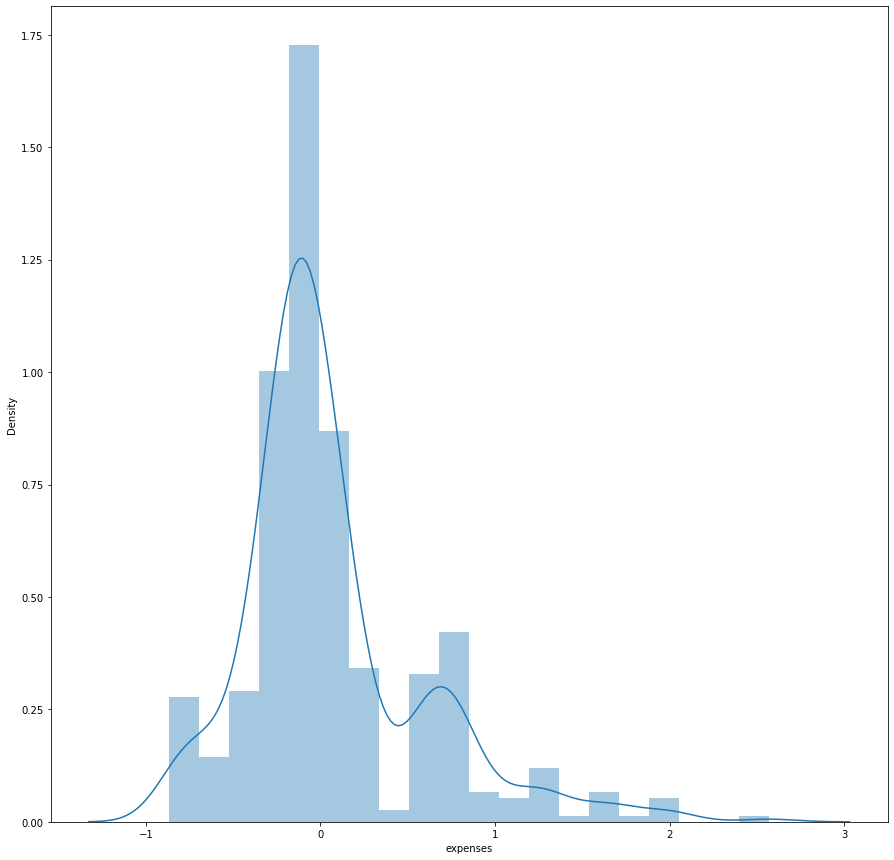

In [56]:
fig_19, axs_19 = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
sns.distplot((y_test - y_pred), bins = 20)

### Random Forest Regressor

In [57]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [58]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [59]:
rf_mse = mean_squared_error(y_test, y_pred)
np.sqrt(rf_mse)

0.3993874019584629

In [60]:
r2_score(y_test, y_pred)

0.8669523228599396

Through the most basic level of the random forest regressor, we have achieved a significant improvement in R2 and RMSE at 86.70% and 0.3994, respectively. However, this must be approached with caution since the model might be overfitting/underfitting the prediction and, in turn, makes it unreliable. Optimal parameters for this regressor were sought to fit the data better. 

<AxesSubplot:xlabel='expenses', ylabel='Density'>

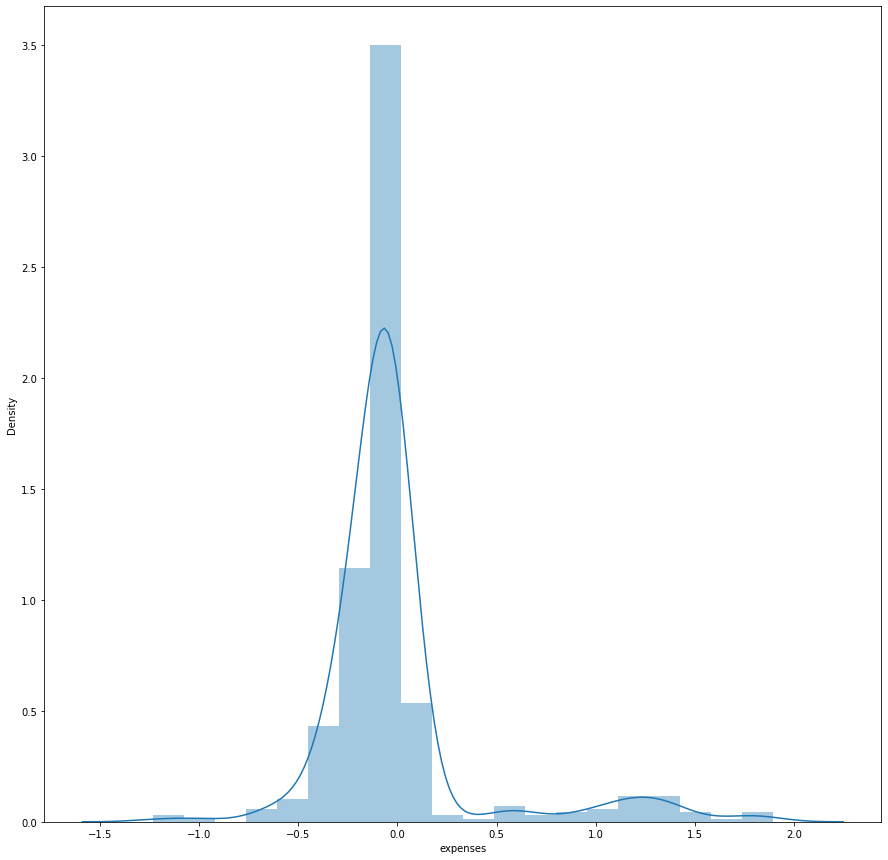

In [61]:
fig_20, axs_20 = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
sns.distplot((y_test - y_pred), bins = 20)

#### Grid Search

In [62]:
from sklearn.model_selection import GridSearchCV

parameters ={'n_estimators':[int(x) for x in np.linspace(start=100, stop=500, num=10)],
             'max_depth':[4, 6],
             'min_samples_split':[4, 6],
             'min_samples_leaf':[2, 3],
            'random_state':[42]}

In [63]:
rf_imp= RandomForestRegressor()
rf_Grid = GridSearchCV(estimator=rf_imp, param_grid=parameters, cv=5, verbose=3)

In [64]:
rf_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42;, score=0.831 total time=   0.2s
[CV 2/5] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42;, score=0.848 total time=   0.3s
[CV 3/5] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42;, score=0.868 total time=   0.2s
[CV 4/5] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42;, score=0.867 total time=   0.2s
[CV 5/5] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42;, score=0.843 total time=   0.3s
[CV 1/5] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=144, random_state=42;, score=0.832 total time=   0.4s
[CV 2/5] END max_depth=4, min_samples_leaf=2, min_samples_split=4, n_estimators=144, random_state=42;, score=0.848 total time=   0.7s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 6], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [4, 6],
                         'n_estimators': [100, 144, 188, 233, 277, 322, 366,
                                          411, 455, 500],
                         'random_state': [42]},
             verbose=3)

In [65]:
rf_Grid.best_params_

{'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 500,
 'random_state': 42}

#### Improved Random Forest

In [66]:
rf_imp = RandomForestRegressor(**rf_Grid.best_params_)
rf_imp.fit(X_train, y_train)
y_pred = rf_imp.predict(X_test)

In [67]:
rf_mse = mean_squared_error(y_test, y_pred)
np.sqrt(rf_mse)

0.3897629994588549

In [68]:
r2_score(y_test, y_pred)

0.8732874032808368

With new parameters, the metrics improved to 87.33% in R2 and 0.3898 in RMSE

<AxesSubplot:xlabel='expenses', ylabel='Density'>

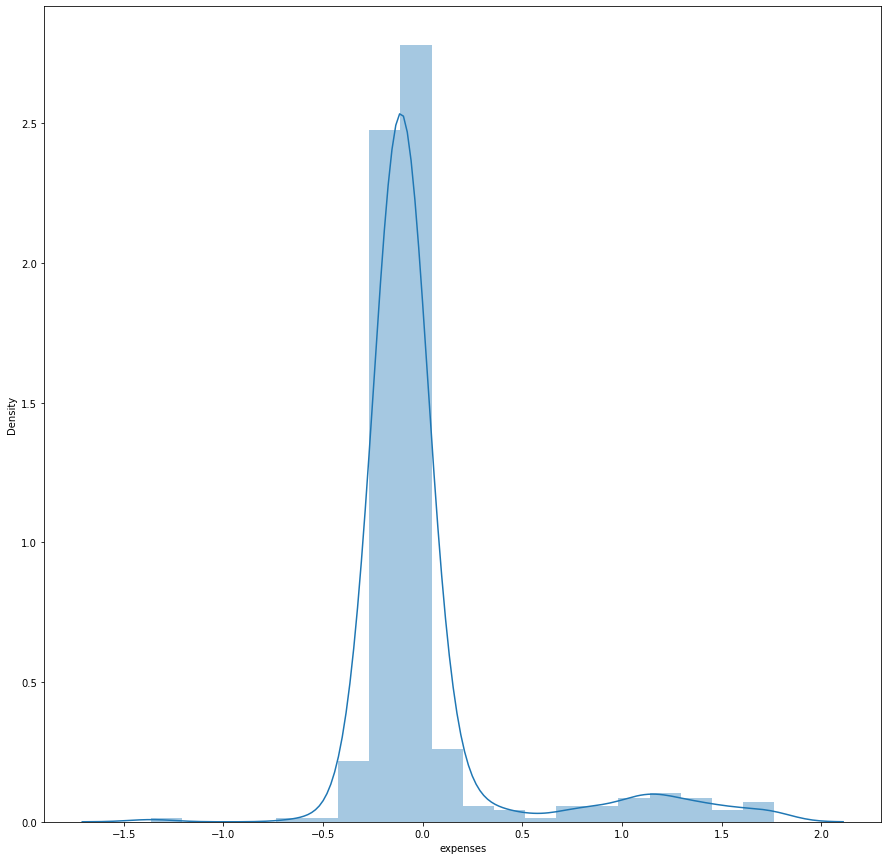

In [69]:
fig_21, axs_21 = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
sns.distplot((y_test - y_pred), bins = 20)

### XGBoost Regressor

In [70]:
from xgboost import XGBRegressor
xgb_reg =  XGBRegressor(objective="reg:squarederror", eval_metric='rmse', random_state=42)

In [71]:
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

In [72]:
rfr_mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(rfr_mse))

0.4384696683738196


In [73]:
r2_score(y_test, y_pred)

0.8396393952807713

Similar to the previous model, we have achieved a larger R2 and lesser RMSE compared to the base model. To avoid bias, optimal parameters were once again identified to fit the data better.

#### Grid Search

In [74]:
parameters ={'booster': ['gbtree'],
             'objective':['reg:squarederror'],
             'eval_metric':['rmse'],
             'learning_rate':[0.05, 0.1, 0.15, 0.2],
             'min_child_weight':[2, 4, 6, 8, 10],
             'max_depth':[4, 6, 8, 10],
             'colsample_bytree': [0.5, 0.75, 1],
            'random_state':[42]}

In [75]:
xgb_imp= XGBRegressor()
xgb_Grid = GridSearchCV(estimator=xgb_imp, param_grid=parameters, cv=5, verbose=3)

In [76]:
xgb_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.5, eval_metric=rmse, learning_rate=0.05, max_depth=4, min_child_weight=2, objective=reg:squarederror, random_state=42;, score=0.815 total time=   0.1s
[CV 2/5] END booster=gbtree, colsample_bytree=0.5, eval_metric=rmse, learning_rate=0.05, max_depth=4, min_child_weight=2, objective=reg:squarederror, random_state=42;, score=0.832 total time=   0.1s
[CV 3/5] END booster=gbtree, colsample_bytree=0.5, eval_metric=rmse, learning_rate=0.05, max_depth=4, min_child_weight=2, objective=reg:squarederror, random_state=42;, score=0.857 total time=   0.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.5, eval_metric=rmse, learning_rate=0.05, max_depth=4, min_child_weight=2, objective=reg:squarederror, random_state=42;, score=0.843 total time=   0.1s
[CV 5/5] END booster=gbtree, colsample_bytree=0.5, eval_metric=rmse, learning_rate=0.05, max_depth=4, min_child_weight=2, objective=reg:squa

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'booster': ['gbtree'],
                         'colsample_bytree': [0.5, 0.75, 1],
                         'eval_metric': ['rmse'],
                         'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10],
                         'min_child_weight': [2, 4, 6, 8, 10],
                         'objective': ['reg:squarederror'],
                         'random_state': [42]},
             verbose=3)

In [77]:
xgb_Grid.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 1,
 'eval_metric': 'rmse',
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 10,
 'objective': 'reg:squarederror',
 'random_state': 42}

#### Improved XGBoost

In [78]:
best_params = {'booster': 'gbtree',
 'colsample_bytree': 1,
 'eval_metric': 'rmse',
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 10,
 'objective': 'reg:squarederror',
 'random_state': 42}

In [79]:
xgb_imp = XGBRegressor(**best_params)
xgb_imp.fit(X_train, y_train)
y_pred = xgb_imp.predict(X_test)

In [80]:
xgb_mse = mean_squared_error(y_test, y_pred)
np.sqrt(xgb_mse)

0.3877139005096066

In [81]:
r2_score(y_test, y_pred)

0.8746162319776536

The XGBoost Regressor incurred the highest R2 score and lowest RMSE at 87.46% and 0.3877, respectively.

<AxesSubplot:xlabel='expenses', ylabel='Density'>

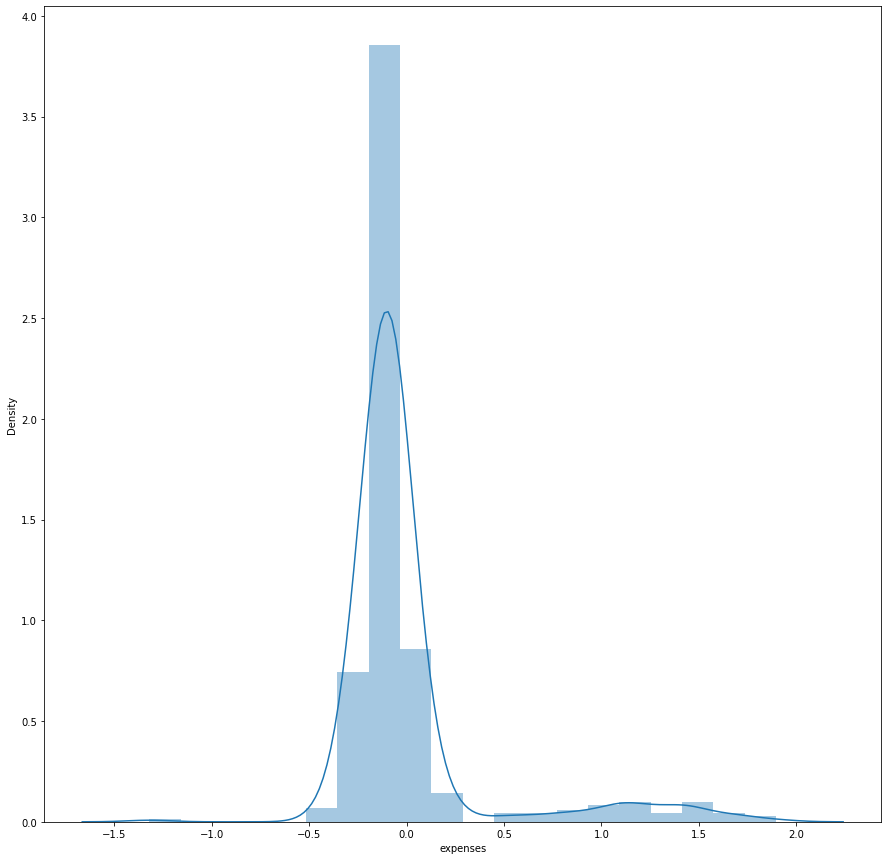

In [82]:
fig_22, axs_22 = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
sns.distplot((y_test - y_pred), bins = 20)

## Top Features

In [83]:
important_features = []
important_features_score = []
for i in range(len(xgb_imp.feature_importances_)):
    if xgb_imp.feature_importances_[i] > 0.001:
        important_features.append(X_train.columns[i])
        important_features_score.append(round(xgb_imp.feature_importances_[i], 3))

df_feature_ranking = pd.DataFrame({'feature': important_features, 'score': important_features_score}).sort_values('score', ascending=False)
print(df_feature_ranking)

            feature  score
8         smoker_no  0.896
0               bmi  0.045
1               age  0.033
2          children  0.007
5  region_northwest  0.006
4  region_northeast  0.004
7  region_southwest  0.004
3        sex_female  0.003
6  region_southeast  0.002


To conclude, the three most important features according to the XGBoost model are the **smoking habit, bmi, and age**